In [3]:
# #hide
# !pip install fastai==2.1.5
# !pip install fastai2==0.0.30
# !pip install fastcore==1.3.5

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
!ls

     |████████████████████████████████| 727kB 8.6MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 194kB 15.1MB/s 
     |████████████████████████████████| 1.1MB 21.1MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 40kB 6.7MB/s 
     |████████████████████████████████| 92kB 10.1MB/s 
     |████████████████████████████████| 61kB 10.7MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 2.6MB 34.4MB/s 
Mounted at /content/gdrive
gdrive	sample_data


In [4]:
import pandas as pd
from fastai.data.all import *
from fastai.vision.all import *
import fastai
import os
from PIL import Image
from google.colab import drive

# drive.mount('/content/gdrive')
# # os.system('cd gdrive/My\ Drive/Colab\ Notebooks/Capstone3')
# # os.getcwd()
# !ls

## For the first step, lets import our authentication for the Kaggle API.

In [5]:
from google.colab import files

! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list


Saving kaggle.json to kaggle.json


Step 1: Data Wragnling
Here we will directly use a set of data coming from Kaggle by applying the URL

In [6]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection
!unzip \*.zip  && rm *.zip
os.chdir('real_and_fake_face')
!ls

 99% 428M/431M [00:06<00:00, 84.6MB/s]
100% 431M/431M [00:06<00:00, 75.0MB/s]
Archive:  real-and-fake-face-detection.zip
  inflating: real_and_fake_face/training_fake/easy_100_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_101_0010.jpg  
  inflating: real_and_fake_face/training_fake/easy_102_0101.jpg  
  inflating: real_and_fake_face/training_fake/easy_103_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_104_1000.jpg  
  inflating: real_and_fake_face/training_fake/easy_105_1100.jpg  
  inflating: real_and_fake_face/training_fake/easy_106_0011.jpg  
  inflating: real_and_fake_face/training_fake/easy_107_1011.jpg  
  inflating: real_and_fake_face/training_fake/easy_108_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_109_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_10_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_110_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_111_1101.jpg  
  inflating: real_and_

Ok lets check if the Image are downloaded correctly

mid_245_1100.jpg


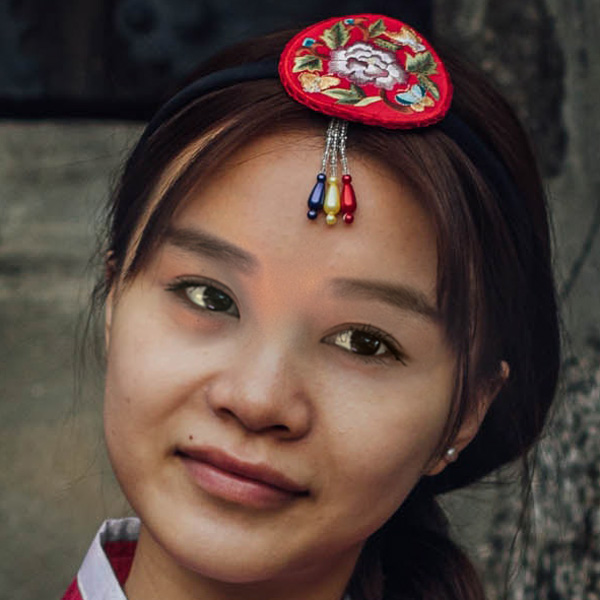

In [7]:
fake_fns = get_image_files('training_fake')
image_path = os.getcwd()/fake_fns[0]
im = Image.open(image_path)
print(os.listdir('training_fake')[0])
im

real_00897.jpg


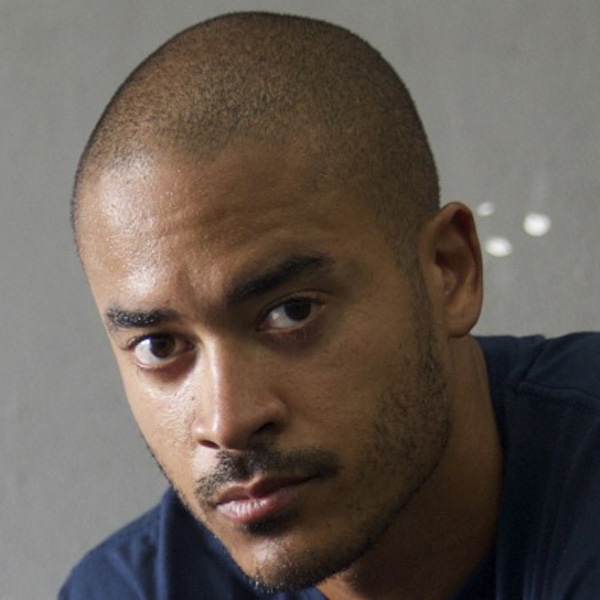

In [8]:
real_fns = get_image_files('training_real')
image_path = os.getcwd()/real_fns[0]
im = Image.open(image_path)
print(os.listdir('training_real')[0])
im

Ok the picture looks.  Now let make a data loader

In [9]:
faces = DataBlock(blocks=(ImageBlock, CategoryBlock),
          get_items = get_image_files,
          splitter = RandomSplitter(valid_pct= 0.2, seed = 42),
          get_y=parent_label,
          item_tfms = Resize(128))
#get_image files get all the image from certain path
#parent label = use parent's folder name as your label

We have not generate a template for our datablock let see if we can enter some data in it.  

**DataLoader vs DataSet in pyTorch**.  Data loader fetches data from a data set and serves the data up in batches, while datasets loads the traing or test data into memory

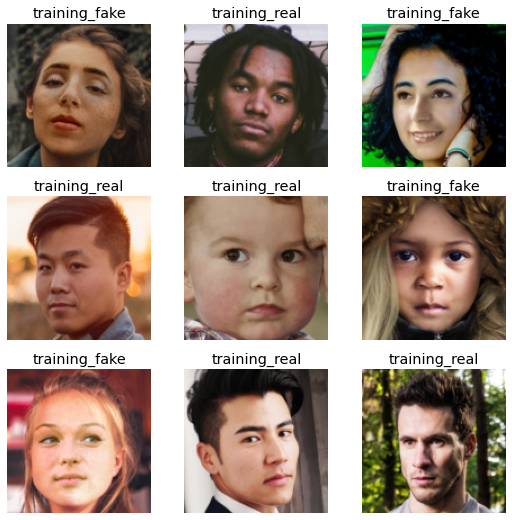

In [10]:
image_path = os.getcwd()
dls = faces.dataloaders(image_path)
dls.vocab 
dls.show_batch()
#image_path = os.getcwd() +'/training_fake'
#faces.datasets(image_path)

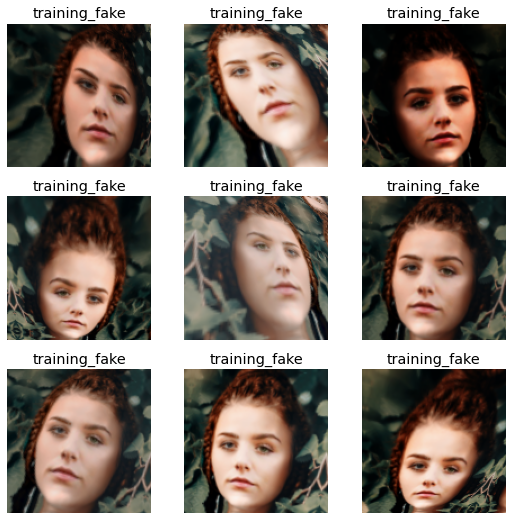

In [11]:
faces = faces.new(item_tfms=Resize(128), batch_tfms =aug_transforms(mult=2) )
dls = faces.dataloaders(image_path)
dls.show_batch(unique= True)

In [12]:
import torchvision.models as models
#model = models.mobilenet_v2(pretrained=True)
learn = Learner(dls, models.mobilenet_v2(pretrained=True)  , metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


epoch,train_loss,valid_loss,error_rate,time
0,5.397808,1.135568,0.526961,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.714724,0.640969,0.367647,00:23
1,0.667661,0.867739,0.419118,00:22
2,0.662661,0.716803,0.357843,00:22
3,0.637922,0.785607,0.389706,00:22
4,0.606347,0.573378,0.311274,00:22
5,0.585659,0.556287,0.291667,00:22
6,0.534889,0.493409,0.227941,00:22
7,0.478349,0.551457,0.269608,00:22
8,0.428056,0.494196,0.237745,00:22
9,0.396303,0.500798,0.220588,00:22


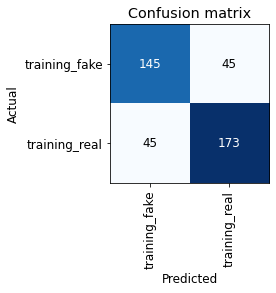

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

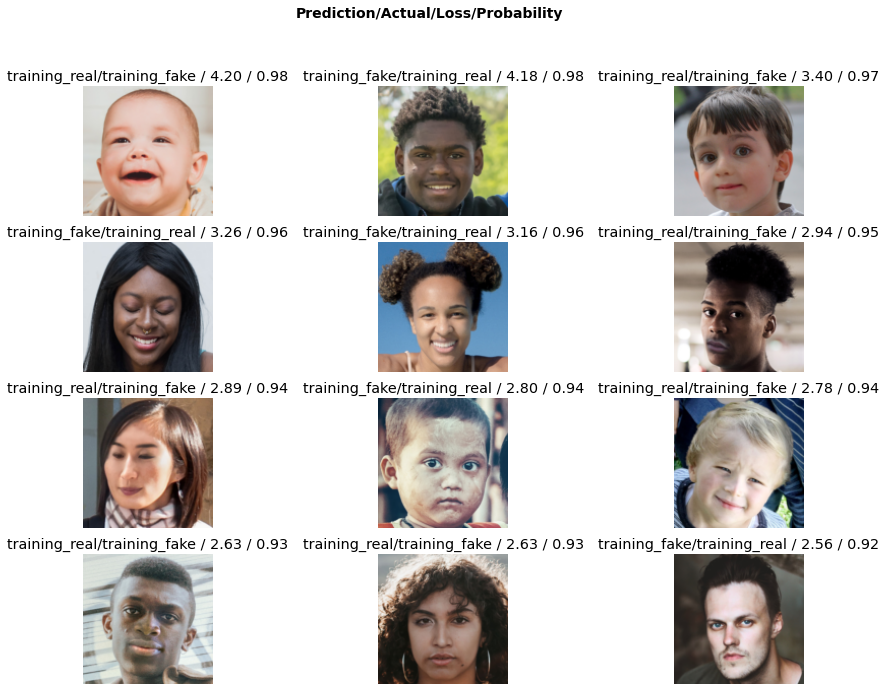

In [14]:
interp.plot_top_losses(12 ,nrows =4, figsize=(15,11))

Ok, now, we will use a custom head (or convolution/classifcation layers) for and see if we can get some improvement on our model

In [15]:
head = nn.Sequential(
    AdaptiveConcatPool2d(),
    Flatten(full=False),
    nn.Linear(2560, out_features=256,bias = True),
    nn.ReLU(inplace=True),
    BatchNorm(256, ndim= 1 ),
    nn.Dropout(0.4, inplace=True),
    nn.Linear(256, out_features=64,bias = False),
    nn.ReLU(inplace=True),
    BatchNorm(64, ndim= 1 ),
    nn.Dropout(0.1, inplace=True),
    nn.Linear(64, out_features=2, bias = False),
    nn.Softmax(dim=1)
)

model1 = create_cnn_model(models.mobilenet_v2, n_out=2, cut = -1, custom_head= head ,pretrained=True)
learn2 = Learner(dls, model= model1, loss_func=nn.CrossEntropyLoss() ,metrics = error_rate ,lr = 0.0001)
#print(head)
#learn2.summary()
learn2.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.710535,0.671934,0.375000,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.670108,0.639651,0.335784,00:22
1,0.662556,0.664344,0.375000,00:21
2,0.660789,0.707348,0.409314,00:22
3,0.649879,0.628959,0.325980,00:22
4,0.636235,0.677235,0.382353,00:22
5,0.629164,0.616318,0.328431,00:22
6,0.614525,0.588448,0.299020,00:22
7,0.594669,0.592568,0.318627,00:22
8,0.580467,0.586433,0.313726,00:21
9,0.569187,0.585901,0.308824,00:22


SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=7.585775847473997e-07)

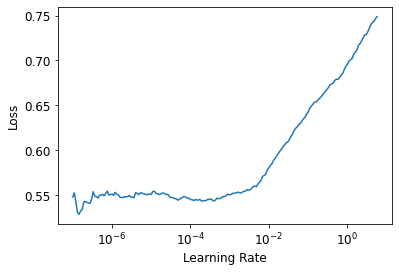

In [16]:
learn2.lr_find(stop_div=False, num_it=200)


In [17]:
import shutil

def make_wking_folder(difficulty):
  #difficulty = easy, mid, or hard
  shutil.rmtree('wking_folder', ignore_errors = True)
  os.mkdir('wking_folder')
  os.mkdir('wking_folder/' + difficulty + '_train')
  working_directory  = 'wking_folder/' + difficulty + '_train'
  for f in os.listdir('training_fake'):
    if f.startswith(difficulty):
      shutil.copyfile('training_fake/'+ f, working_directory+ '/' + f)
  shutil.copytree('training_real', 'wking_folder/' + 'training_real')

make_wking_folder('easy')


In [18]:
def training_models():
  faces = DataBlock(blocks=(ImageBlock, CategoryBlock),
            get_items = get_image_files,
            splitter = RandomSplitter(valid_pct= 0.2, seed = 42),
            get_y=parent_label,
            item_tfms = Resize(128))
  image_path = os.getcwd() + '/wking_folder'
  dls = faces.dataloaders(image_path)
  dls.show_batch()
  learn = Learner(dls, models.mobilenet_v2(pretrained=True)  , metrics=error_rate)
  learn.fine_tune(30)

epoch,train_loss,valid_loss,error_rate,time
0,6.918216,3.724850,0.166667,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.475931,0.492923,0.181818,00:14
1,0.331116,0.531423,0.166667,00:14
2,0.222889,0.688999,0.166667,00:14
3,0.175041,1.020613,0.246212,00:14
4,0.158106,1.123067,0.178030,00:14
5,0.157462,0.706619,0.223485,00:15
6,0.152670,0.702937,0.174242,00:14
7,0.135052,0.583956,0.162879,00:15
8,0.122078,0.732291,0.147727,00:15
9,0.106093,0.580389,0.132576,00:15


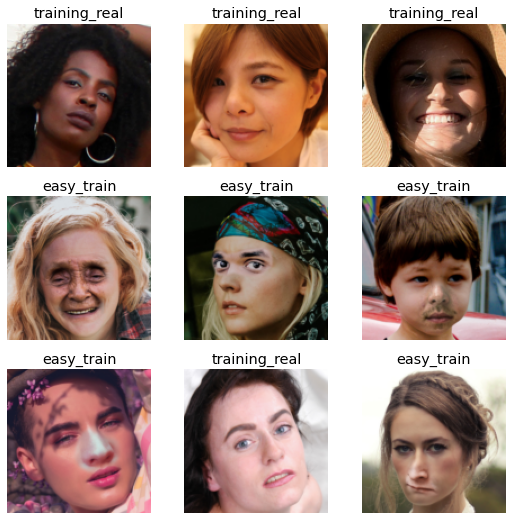

In [19]:
make_wking_folder('easy')
training_models()

In [ ]:
make_wking_folder('mid')
training_models()

epoch,train_loss,valid_loss,error_rate,time
0,6.447989,1.972754,0.219697,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.374799,0.956558,0.223485,00:15
1,0.251071,0.799006,0.219697,00:15
2,0.161797,1.340838,0.223485,00:15
3,0.133356,1.318695,0.231061,00:16
4,0.138129,2.176001,0.454545,00:16
5,0.133018,1.255244,0.208333,00:16
6,0.135641,0.912754,0.268939,00:16
7,0.116694,1.119700,0.268939,00:16
8,0.101148,1.015287,0.196970,00:16
9,0.087091,1.243926,0.231061,00:15


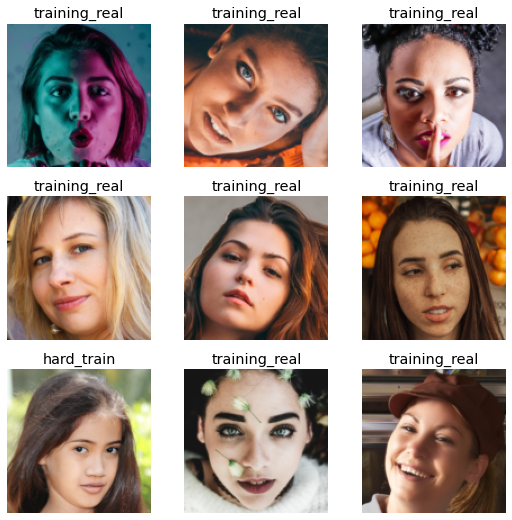

In [21]:
make_wking_folder('hard')
training_models()

We will take out the model and use it to make an apps

In [54]:
learn.export('real_fake_face.pkl')
path = Path()
path.ls(file_exts='.pkl')
!ls ..

gdrive	     real_and_fake_face		   sample_data
kaggle.json  real_and_fake_face_detection


In [60]:
shutil.copyfile('real_fake_face.pkl','/content/gdrive/MyDrive/Colab Notebooks/Capstone3/real_fake_face.pkl')
!ls ../gdrive/MyDrive/Colab\ Notebooks/Capstone3

'Capstone Project 3.ipynb'   real_fake_face.pkl
